## PCB Defect Detection: Object Detection (Version 2)

Dataset Source: https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8

#### Install Necessary Libraries Not Already Installed

In [1]:
%pip install transformers evaluate datasets tensorboard albumentations timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

#### Import Necessary Libraries

In [2]:
import os, sys, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations

from PIL import ImageDraw
import PIL.Image
from IPython.display import Image, display

from tqdm import tqdm
import torchvision
import evaluate

import transformers
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from transformers import TrainingArguments, Trainer
from transformers import DetrImageProcessor

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

import datasets
from datasets import load_dataset

#### Access to HuggingFace Hub

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Display Versions of Relevant Libraries

In [4]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Torch Vision:".rjust(15), torchvision.__version__)

        Python: 3.9.16
         NumPy: 1.22.4
        Pandas: 1.4.4
  Transformers: 4.27.4
         Torch: 1.13.1+cu116
  Torch Vision: 0.14.1+cu116


#### Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### COCO Detection Class

In [6]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in COCO format of both PIL image & target
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, 
                                  annotations=target, 
                                  return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() #remove batch dimension
        target = encoding["labels"][0] #remove batch dimension

        return pixel_values, target

#### Ingest Data

In [7]:
parent_dir = "/content/drive/MyDrive/PCB Defect Detection"

img_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_ds = CocoDetection(img_folder=os.path.join(parent_dir, 'valid'), 
                              processor=img_processor)

eval_ds = CocoDetection(img_folder=os.path.join(parent_dir, 'test'), 
                            processor=img_processor, 
                            train=False)

/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=1.86s)
creating index...
index created!
loading annotations into memory...
Done (t=1.23s)
creating index...
index created!


#### Display Sample Size of Training & Evaluation Datasets

In [8]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(eval_ds)} samples in it.")

The training dataset has 468 samples in it.
The testing dataset has 288 samples in it.


#### Display Information About Example Sample

In [9]:
pixel_values, target = train_ds[2]
print(pixel_values.shape)
print(target.keys())

torch.Size([3, 800, 800])
dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


#### Visualize Example

Image n°209


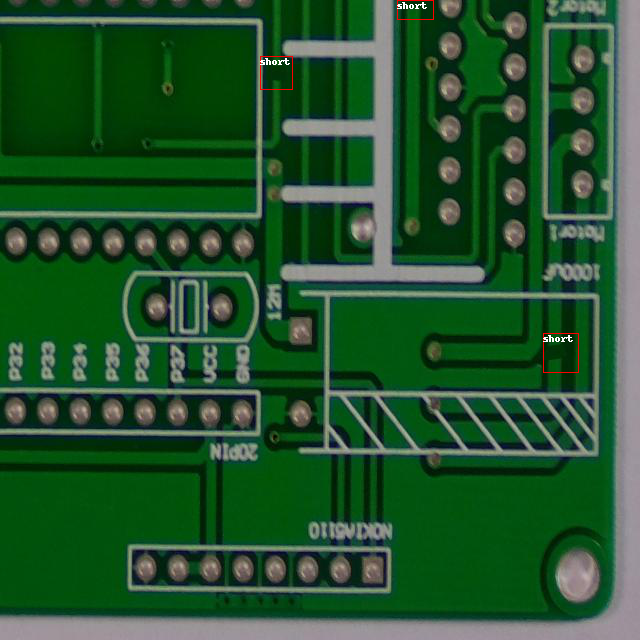

In [10]:
categories = ["missing hole", "mouse bite", "open circuit", "short", "spur", "spurious copper"]
NUM_LABELS = len(categories)

id2label = {k: v for k, v in enumerate(categories)}
label2id = {v: k for k, v in id2label.items()}

image_ids = train_ds.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_ds.coco.loadImgs(image_id)[0]
image = PIL.Image.open(os.path.join(parent_dir, "valid", image['file_name']))

annotations = train_ds.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

#### Basic Values/Constants

In [11]:
MODEL_CKPT = "facebook/detr-resnet-50"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-PCB_Defect_Detection_v2"

BATCH_SIZE = 8
DEVICE = torch.device("cuda")

LEARNING_RATE = 1e-5
NUM_OF_EPOCHS = 60

WEIGHT_DECAY = 1e-4
STRATEGY = "steps"

REPORTS_TO = "tensorboard"

#### Define Data Collator

In [12]:
def collate_function(batch):
  pixel_values = [item[0] for item in batch]
  encoding = img_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

#### Instantiate Model

In [13]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    save_strategy=STRATEGY,
    save_steps=int(59*2),
    logging_strategy=STRATEGY,
    logging_steps=59,
    evaluation_strategy=STRATEGY,
    eval_steps=int(NUM_OF_EPOCHS * 59) + 1,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    remove_unused_columns=False,
    fp16=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_function,
    train_dataset=train_ds,
    tokenizer=img_processor,
)

Cloning https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection_v2 into local empty directory.


#### Train Model

In [17]:
training_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Step,Training Loss,Validation Loss


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/pytho

#### Push Model to Hub (My Profile!!!!)

In [18]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/159M [00:00<?, ?B/s]

Upload file runs/Mar30_19-54-10_6fe411c3efc6/events.out.tfevents.1680206062.6fe411c3efc6.229.0:   0%|         …

To https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection_v2
   ce0ee81..7c228d2  main -> main

   ce0ee81..7c228d2  main -> main

To https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection_v2
   7c228d2..3ea7fcc  main -> main

   7c228d2..3ea7fcc  main -> main



'https://huggingface.co/DunnBC22/detr-resnet-50-PCB_Defect_Detection_v2/commit/7c228d2892f8c91f3056c3db670d7a679a3b106f'

### Notes & Other Takeaways
****
- The toughest part of training both object detection and image segmentation models is that they require better hardware than what I have.

****

#### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2005-12872, author = {Nicolas Carion and Francisco Massa and Gabriel Synnaeve and Nicolas Usunier and Alexander Kirillov and Sergey Zagoruyko}, title = {End-to-End Object Detection with Transformers}, journal = {CoRR}, volume = {abs/2005.12872}, year = {2020}, url = {https://arxiv.org/abs/2005.12872}, archivePrefix = {arXiv}, eprint = {2005.12872}, timestamp = {Thu, 28 May 2020 17:38:09 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2005-12872.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @misc{ pcb-defect-detection-hdqc8_dataset, title = { PCB defect detection Dataset }, type = { Open Source Dataset }, author = { SRTImageDefectDetection }, howpublished = { \url{ https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8 } }, url = { https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8 }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { sep }, note = { visited on 2023-07-30 },}